# Corpus Statistics

## GOV1

* Missing Documents: **{{1247753 - evaluation['gov1']['document-count'] }}**
  * We have **{{evaluation['gov1']['document-count']}}** documents and expect 1,247,753 (reported by Bernstein et al.)
  * Probably due to Anserinis skipping of "un-indexable documents"

* Distribution of retrieval-equivalent set-sizes in GOV1, on log-log axes

{{gov1_retrieval_equivalent_set_sizes}}

* Percent of Duplicates: {{percent_of_duplicate_documents('gov1')}}
* Word-8-Gramms over all documents



## GOV2

* Missing Documents: **{{25205179 - evaluation['gov2']['document-count']}}**
  * We have **{{evaluation['gov2']['document-count']}}** documents and expect 25,205,179 (reported by Bernstein et al.)
  * Probably due to Anserinis skipping of "un-indexable documents"

* Distribution of retrieval-equivalent set-sizes in GOV2, on log-log axes

{{gov2_retrieval_equivalent_set_sizes}}

* Percent of Duplicates: {{percent_of_duplicate_documents('gov2')}}

### Sketch: S3-Near Duplicates between All Judged Documents and Corpus XX

Gov2 has **128010** judged documents.
If we assume the following approach works on Gov2,
it should also work on larger corpora like ClueWeb09 or ClueWeb12 (since the number of judged documents is smaller).

1.  MapReduce-Job: Extract all word-8-gramms from judged documents
     *  In Gov2, this results in **{{gov2_word_8_gramms}}** word-8-Gramms
     *  I assume that the amount of word-8-gramms is similar for ClueWeb09, ClueWeb12 etc.
2.  MapReduce-Job
     * Load all word-8-gramms + Build a Bloom-Filter
       * [The associated Bloom-Filter would require 700 MiB](https://hur.st/bloomfilter/?n=400000000&p=1.0E-3&m=&k=)
     * Extract word-8-grams from all documents, each word-8-gram not in the bloom-filter is discarded
       * 1 in 1000 word-8-gramms should be a false positive
     * Calculate S3-Score on the index

  
## ClueWeb09

* We have **{{evaluation['clueweb09']['document-count']}}** documents and expect 1,040,809,705 web pages

{{clueweb09_retrieval_equivalent_set_sizes}}

* Percent of Duplicates: {{percent_of_duplicate_documents('clueweb09')}}

## ClueWeb12


* We have **{{evaluation['clueweb12']['document-count']}}** documents and expect 733,019,372 web pages?

{{clueweb12_retrieval_equivalent_set_sizes}}

* Percent of Duplicates: {{percent_of_duplicate_documents('clueweb12')}}

## Common Core 2017

* We have **{{evaluation['core2017']['document-count']}}** documents and expect > 1,800,000 

* Distribution of retrieval-equivalent set-sizes in Core 2017, on log-log axes

{{core2017_retrieval_equivalent_set_sizes}}

* Percent of Duplicates: {{percent_of_duplicate_documents('core2017')}}

## Common Core 2018

* We have **{{evaluation['core2018']['document-count']}}** documents and expect 608,180 web pages

* Distribution of retrieval-equivalent set-sizes in Core 2018, on log-log axes

{{core2018_retrieval_equivalent_set_sizes}}

* Percent of Duplicates: {{percent_of_duplicate_documents('core2018')}}


# Notes

* I want to give a broad overview over several years:
  * [terabyte (2004-2006)](https://trec.nist.gov/data/terabyte.html)
  * [web (2009-2014; discarding really old stuff?)](https://trec.nist.gov/data/webmain.html)
  * [Common-Core (2017+2018)](https://trec.nist.gov/data/core.html)

# ToDos

* Multiple Figures (For each : x-Axis: Rank of Run (best run position 1, worst on last rank); y-Axis the score-changes for the run on position ... : To Verify the statement of bernstein

In [ ]:
from notebook_util import raise_if_success_file_is_missing
COLLECTIONS = [
    'gov1',
    'gov2',
    'clueweb09',
    'clueweb12',
    'common',
    'core2017',
    'core2018'
]

HASH_GROUPING_KEYS = [
    'canonicalized_md5_content',
    'canonicalized_text_profile_signature',
    'md5_content',
    'text_profile_signature'
]

MATPLOTLIB_FONT = {
    'family' : 'normal',
    'weight' : 'normal',
    'size'   : 12
}

MATPLOT_SIZE_FULL_WIDTH = (4.7, 2.35)
MATPLOT_SIZE_HALF_WIDTH = (2.35, 1.5)

import matplotlib
matplotlib.rc('font', **MATPLOTLIB_FONT)


sc

In [2]:
import json

def hash_goup_evaluation_for_collection_with_hash_key(collection, hash_key):
    hash_group_dir = 'trec-fingerprint-groups-' + collection + '/' + hash_key
    try:
        raise_if_success_file_is_missing(hash_group_dir, sc)
    except:
        return None
    
    return sc.textFile(hash_group_dir + '/part*').map(lambda d: json.loads(d)['hash']).count()


def transform_rdd_to_set_size_entries(rdd):
    return rdd\
        .map(lambda d: (len(json.loads(d)['ids']), 1))\
        .groupByKey()\
        .map(lambda d: (d[0], sum(d[1])))\
        .collect()

def set_size_to_number_of_sets_for_collection(collection):
    directory = 'trec-fingerprint-groups-' + collection + '/canonicalized_md5_content'
    try:
        raise_if_success_file_is_missing(directory, sc)
    except:
        return None
    
    return transform_rdd_to_set_size_entries(sc.textFile(directory))

def transform_rdd_to_duplicate_count(rdd):
    return rdd\
        .map(lambda d: (1, len(json.loads(d)['ids'])))\
        .reduce(lambda a,b: (a[0]+b[0], a[1] + b[1]))

def set_duplicate_count_for_collection(collection):
    directory = 'trec-fingerprint-groups-' + collection + '/canonicalized_md5_content'
    try:
        raise_if_success_file_is_missing(directory, sc)
    except:
        return None
    
    return transform_rdd_to_duplicate_count(sc.textFile(directory))

def evaluate_collection(collection):
    import json
    collection_dir = 'trec-ndd-hashes-' + collection
    
    try:
        raise_if_success_file_is_missing(collection_dir, sc)
    except:
        return None
    
    ret = {
        'document-count': sc.textFile(collection_dir + '/part*').map(lambda d: json.loads(d)['id']).count()
    }
    
    for hash_key in HASH_GROUPING_KEYS:
        ret[hash_key] = {
            'group-count': hash_goup_evaluation_for_collection_with_hash_key(collection, hash_key)
        }
    
    return ret
    
def evaluate_all_collections():
    ret = {}
    for collection in COLLECTIONS:
        ret[collection] = evaluate_collection(collection)
        if ret[collection] is not None:
            ret[collection]['set_size'] = set_size_to_number_of_sets_for_collection(collection)
            ret[collection]['duplicate_sizes'] = set_duplicate_count_for_collection(collection)
    return ret


evaluation = evaluate_all_collections()

In [3]:
evaluation['core2018']['document-count']

595037

In [3]:
ids = sc.textFile('trec-fingerprint-groups-gov2/canonicalized_md5_content/part*')\
    .map(lambda d: len(json.loads(d)['ids']))

print('Groups: ' + str(ids.count()))
print('Near-Duplicated-Documents: ' + str(ids.sum()))
print('Max Near-Duplicated-Documents per Group: ' + str(ids.max()))
print('Avg Near-Duplicated-Documents per Group: ' + str(ids.mean()))

Groups: 794889
Near-Duplicated-Documents: 6682306
Max Near-Duplicated-Documents per Group: 512482
Avg Near-Duplicated-Documents per Group: 8.406590102517455


In [4]:
def percent_bar_chart(counts, plot_name):
    import matplotlib.pyplot as plt
    from IPython.display import Image
    
    fig = plt.figure()
    plt.scatter(x=[i[0] for i in counts], y=[i[1] for i in counts])
    
    plt.yscale('log')
    plt.ylabel('Number of Sets')
    
    plt.xscale('log')
    plt.xlabel('Set Size')

    plt.savefig(plot_name)
    plt.close()
    return Image(plot_name + '.png')

gov1_retrieval_equivalent_set_sizes = percent_bar_chart(evaluation['gov1']['set_size'], 'gov1-retrieval-equivalent-set-sizes')
gov2_retrieval_equivalent_set_sizes = percent_bar_chart(evaluation['gov2']['set_size'], 'gov2-retrieval-equivalent-set-sizes')
core2017_retrieval_equivalent_set_sizes = percent_bar_chart(evaluation['core2017']['set_size'], 'core2017-retrieval-equivalent-set-sizes')
core2018_retrieval_equivalent_set_sizes = percent_bar_chart(evaluation['core2018']['set_size'], 'core2018-retrieval-equivalent-set-sizes')
clueweb09_retrieval_equivalent_set_sizes = percent_bar_chart(evaluation['clueweb09']['set_size'], 'clueweb09-retrieval-equivalent-set-sizes')
clueweb12_retrieval_equivalent_set_sizes = percent_bar_chart(evaluation['clueweb12']['set_size'], 'clueweb12-retrieval-equivalent-set-sizes')


In [9]:
import json

def group_by_counts(bla):
    return bla.groupByKey()\
    .map(lambda d: (d[0], len(d[1])))\
    .collect()

raise_if_success_file_is_missing('trec-8-gramm-index-gov1-spex-all', sc)


group_by_counts(sc.textFile('trec-8-gramm-index-gov1-spex-all')\
    .map(lambda d: (len(json.loads(d)['documentIds']), 1)))

[(3000, 1),
 (1000, 7),
 (5001, 1),
 (1001, 19),
 (8001, 1),
 (2, 72221218),
 (2002, 1),
 (6002, 1),
 (1002, 5),
 (3, 15065201),
 (1003, 5),
 (4, 6613361),
 (5, 2538291),
 (1006, 1),
 (6, 1841718),
 (21007, 1),
 (1007, 1),
 (7, 955585),
 (8, 812800),
 (1008, 4),
 (5008, 2),
 (9, 495115),
 (2009, 1),
 (1009, 2),
 (1010, 1),
 (10, 424292),
 (21010, 1),
 (11, 297679),
 (3011, 1),
 (1011, 9),
 (1012, 3),
 (12, 313379),
 (13, 185069),
 (1013, 5),
 (2014, 1),
 (14, 167569),
 (1015, 4),
 (15, 130116),
 (16, 127827),
 (1016, 4),
 (6016, 1),
 (7016, 1),
 (1017, 1),
 (17, 93720),
 (2017, 1),
 (8017, 1),
 (3017, 2),
 (18, 93580),
 (1018, 2),
 (19, 71282),
 (1019, 4),
 (1020, 2),
 (20, 74167),
 (1021, 1),
 (21, 60551),
 (6021, 1),
 (1022, 5),
 (22, 55367),
 (1023, 6),
 (23, 44810),
 (24, 51921),
 (3024, 1),
 (1024, 1),
 (25, 38888),
 (1025, 1),
 (26, 37540),
 (1026, 3),
 (2026, 8),
 (1027, 2),
 (27, 32743),
 (1028, 9),
 (28, 39454),
 (2028, 1),
 (18028, 1),
 (1029, 3),
 (29, 29845),
 (3029, 1),
 (

In [10]:
sc.parallelize([(1,1), (2,1), (2,1), (3,1), (4,1), (1,1)])\
    .groupByKey()\
    .map(lambda d: (d[0], len(d[1])))\
    .collect()


[(1, 2), (2, 2), (3, 1), (4, 1)]

In [11]:
import json


TMP_IDS = [
    '{"hash":"1683fcf2344ef69c77c4cd2e5bf953ff","ids":["G02-94-0144156","G04-99-3015482"]}',
    '{"hash":"03712f0e864eccb9facd466556dbc1ca","ids":["G13-97-2501670","G11-28-2832766"]}',
    '{"hash":"03712f0e864eccb9facd466556dbc1ca","ids":["G13-97-2501670"]}',
    '{"hash":"03712f0e864eccb9facd466556dbc1ca","ids":["G13-97-2501670","G11-28-2832766","G11-28-2832766"]}',
]


set_sizes = set_size_to_number_of_sets_for_collection('gov1')
    

In [12]:
gov2_word_8_gramms = sc.textFile('trec-8-gramm-index-gov2-all-judged').count()

print(sc.textFile('trec-8-gramm-index-gov1-spex-all').count())
print(gov2_word_8_gramms)
print(sc.textFile('trec-8-gramm-index-gov2-spex-judged').count())

103571227
390948445
71599520


In [6]:
MAP_LOSS = {
  "2004-terabyte": [50, 49, 49, 48, 48, 47, 47, 46, 46, 45, 45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39, 39, 38, 38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25],
  "2005-terabyte": [47, 46, 46, 45, 45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39, 39, 38, 38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22],
  "2006-terabyte": [45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39, 39, 38, 38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20],

  "2009-web": [43, 42, 42, 41, 41, 40, 40, 39, 39, 38, 38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18],
  "2010-web": [41, 40, 40, 39, 39, 38, 38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16],
  "2011-web": [39, 38, 38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14],
  "2012-web": [38, 37, 37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13],
  "2013-web": [37, 36, 36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13, 12],
  "2014-web": [36, 35, 35, 34, 34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13, 12, 12, 11],

  "2017-core": [34, 33, 33, 32, 32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10, 9],
  "2018-core": [32, 31, 31, 30, 30, 29, 29, 28, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10, 9, 9, 8, 8, 7]
}

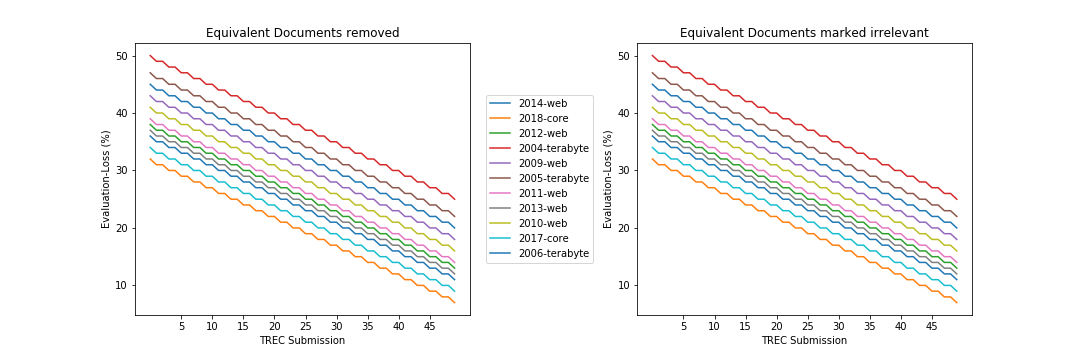

In [7]:
import matplotlib.pyplot as plt
from IPython.display import Image

#fig = plt.figure()
legend = MAP_LOSS.keys()



#plt.legend(legend, loc='center right', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

fig, (equivalent_removed, equivalent_irrelevant) = plt.subplots(ncols=2, figsize=(15, 5))

equivalent_removed.set_ylabel('Evaluation-Loss (%)')
equivalent_removed.set_xlabel('TREC Submission')
equivalent_removed.set_title('Equivalent Documents removed')
equivalent_removed.set_xticks(range(5,50, 5))

equivalent_irrelevant.set_ylabel('Evaluation-Loss (%)')
equivalent_irrelevant.set_xlabel('TREC Submission')
equivalent_irrelevant.set_xticks(range(5,50, 5))
equivalent_irrelevant.set_title('Equivalent Documents marked irrelevant')

color_cycle = plt.rcParams['axes.prop_cycle']()

for k in legend:
    data = MAP_LOSS[k]
    n = next(color_cycle)
    equivalent_removed.plot(range(len(data)), data, label=k, **n)
    equivalent_irrelevant.plot(range(len(data)), data, label=k, **n)


# so far so good, now the trick

lines_labels = [equivalent_removed.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.subplots_adjust(wspace=.5)
fig.legend(lines, labels, loc=(0.45,0.27))

plt.savefig('evaluation-losses')
plt.close()
Image('evaluation-losses.png')

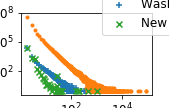

In [66]:
MARKERS = {
    'ClueWeb09': '.',
    'Washington Post': '+',
    'New York Times': 'x'
}

POSITION = {
    'ClueWeb09': 1,
    'Washington Post': 2,
    'New York Times': 3
}
    

def all_counts_dummy_plot(all_counts, plot_name):
    import matplotlib.pyplot as plt
    from IPython.display import Image
    
    fig, ax = plt.subplots(figsize=MATPLOT_SIZE_HALF_WIDTH)
    for c in all_counts.keys():
        counts = all_counts[c]
        ax.scatter(x=[i[0] for i in counts], y=[i[1] for i in counts], label=c, marker=MARKERS[c])
    
    plt.yscale('log')
    plt.ylabel('Number of Sets')
    
    plt.xscale('log')
    plt.xlabel('Set Size')
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: POSITION[t[0]]))
    ax.legend(handles, labels, loc=(0.62,0.73))
    
    plt.savefig(plot_name)
    plt.close()
    return Image(plot_name + '.png')

all_counts_dummy_plot({
    'ClueWeb09': evaluation['clueweb09']['set_size'],
    'Washington Post': evaluation['core2018']['set_size'],
    'New York Times': evaluation['core2017']['set_size']
}, 'near-duplicate-group-sizes')



In [3]:
sc.textFile('trec-fingerprint-groups-clueweb12/canonicalized_md5_content').take(10)

['{"hash":"4e7618dbbc35c24d81c0a7e94cd24c78","ids":["clueweb12-1500tw-26-09198","clueweb12-1500tw-23-08707"]}',
 '{"hash":"aecb50d67c12459fa588ac23fd4cb5ca","ids":["clueweb12-1400wb-06-26117","clueweb12-1400wb-06-26118"]}',
 '{"hash":"0859324828627e8eba4c1e7eddd1d7e1","ids":["clueweb12-0102wb-67-26971","clueweb12-0103wb-85-14706"]}',
 '{"hash":"722cba59bfd40b12e180113a144ded8f","ids":["clueweb12-1612wb-26-29261","clueweb12-1612wb-26-29262","clueweb12-1612wb-26-29263","clueweb12-1612wb-49-00335","clueweb12-1612wb-49-00336","clueweb12-1612wb-49-00337"]}',
 '{"hash":"808f80c88892f707026d390b8314e3dd","ids":["clueweb12-0403wb-21-24838","clueweb12-0403wb-21-24841","clueweb12-0403wb-48-03226","clueweb12-0403wb-04-21488","clueweb12-0403wb-35-02380","clueweb12-0007wb-34-08319","clueweb12-1510wb-84-28956"]}',
 '{"hash":"9503979b1338a9ef875d02d97520a464","ids":["clueweb12-1311wb-08-34956","clueweb12-1310wb-77-17219"]}',
 '{"hash":"3e49ddb0620eca346e8b40f32086ff1b","ids":["clueweb12-1316wb-47-063